#Dependencies

In [ ]:
# !pip3 install flair
# !pip install contractions
# !pip install beautifulsoup4
!pip install bertopic

#Imports


In [ ]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import flair

import os
from ast import literal_eval
import bz2
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re
import numpy as np

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
from nltk.stem.porter import *
stemmer = PorterStemmer()
#print(STOPWORDS)

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#Preprocess

In [ ]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    # print(document)
    # strip HTML
    # document = strip_html_tags(document)
    # document = re.sub(r'[hH][tT][tT][pP][Ss]?:\/\/.*[\r\n]* ?', '', document)
    st=re.search(r'\[([^]]+)\]', document)
    # print(document)
    if(st):
      st=st.group(1)
      document = document.replace(st,"")
      # print(st)
    
    document = ' '.join(word for word in document.split() )#if word.lower() not in STOPWORDS) 
    # document = st+document[]
    document = REPLACE_BY_SPACE_RE.sub(' ', document) 
    # lower case
    document = document.lower()
    # remove links
    
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    # document = remove_accented_chars(document)
    # expand contractions    
    # document = expand_contractions(document)  
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    #special_char_pattern = re.compile(r'([{.(-)!}])')
    #document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=False)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    # document= ' '.join(stemmer.stem(i) for i in document.split())
    document = document.strip()
    if(st):
      sb=st.lower().strip()
      if(len(sb)>1):
        sb+=" "
      document = sb + document
    
    # document = ' '.join(word for word in document.split() if word.lower() not in STOPWORDS) 
    # print(document)
    return document

# a=pre_process_document(appended_data.iloc[4]['quotation'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path_to_file = '/content/drive/MyDrive/ADA/quotes-2019-nytimes.json.bz2' 

c=0

appended_data = []

with bz2.open(path_to_file, 'rb') as s_file:
    
        for instance in s_file:
            c+=1
            instance = json.loads(instance) # loading a sample
            df = pd.json_normalize(instance)
            # df = df.drop(['speaker','qids','date','numOccurrences','probas','urls','phase'], axis=1)
            appended_data.append(df)
            # print(instance)
            if c%100000==0:
              print(c)


data = pd.concat(appended_data)
# quotes = appended_data.drop(['speaker','qids','date','numOccurrences','probas','urls','phase'], axis=1)
data.describe()

100000
200000


,numOccurrences
count,207527.000000
mean,7.698844
std,55.648115
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,12095.000000


In [ ]:
# data=pd.read_csv('/content/drive/MyDrive/DATA_parse/quotes_2016_parse.csv', encoding='UTF-8', compression='bz2', index_col=0, chunksize=100000)
# data = next(data)
#print(len(data))
#n = len(data) // 100000
#data = data.iloc[::n]
# print(len(data))
data.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2019-04-17-024782,"It is not a low-income immigration,",James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E
0,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E
0,2019-05-09-055187,It makes it much more difficult for him to mak...,None,[],2019-05-09 18:11:29,1,"[[None, 0.6493], [President Bill Clinton, 0.27...",[http://mobile.nytimes.com/2019/05/09/world/as...,E
0,2019-10-31-056366,"It puts me in a predicament,",Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E
0,2019-01-04-001792,A Pile of Leaves.,None,[],2019-01-04 10:00:07,1,"[[None, 0.8737], [Jason Fulford, 0.1263]]",[https://www.nytimes.com/2019/01/04/books/revi...,E


In [ ]:
data['quotation'] = data['quotation'].apply(pre_process_document)
data.dropna(subset=['quotation'], inplace=True)
print(len(data))
data.head()

207527


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2019-04-17-024782,it is not a lowincome immigration,James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E
0,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E
0,2019-05-09-055187,it makes it much more difficult for him to mak...,None,[],2019-05-09 18:11:29,1,"[[None, 0.6493], [President Bill Clinton, 0.27...",[http://mobile.nytimes.com/2019/05/09/world/as...,E
0,2019-10-31-056366,it puts me in a predicament,Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E
0,2019-01-04-001792,a pile of leaves,None,[],2019-01-04 10:00:07,1,"[[None, 0.8737], [Jason Fulford, 0.1263]]",[https://www.nytimes.com/2019/01/04/books/revi...,E


dont think impacts trumps standing coal country importantly going go


In [ ]:
data.to_csv('/content/drive/MyDrive/ADA/quote-nytimes.csv')

#NLTK Sentiment Analyzer

In [ ]:
nltk_sentiment = SentimentIntensityAnalyzer()

def classify_sentiment_nltk(doc):
  #  print(doc)
   scores = nltk_sentiment.polarity_scores(doc)
   neg_sc=scores['neg']	
   neu_sc=scores['neu']
   pos_sc=scores['pos']
   compound_sc=scores['compound']
   sentiment=np.argmax(np.array([neg_sc,neu_sc,pos_sc,compound_sc]))
   scores['sentiment'] = sentiment
   return scores
  

applied_df = data.apply(lambda row: classify_sentiment_nltk(row.quotation), axis='columns', result_type='expand')
applied_df.head()

,neg,neu,pos,compound,sentiment
0,0.000,1.000,0.000,0.0000,1.0
0,0.000,0.606,0.394,0.5994,1.0
0,0.189,0.811,0.000,-0.4201,1.0
0,0.000,1.000,0.000,0.0000,1.0
0,0.000,1.000,0.000,0.0000,1.0


In [ ]:
print(data.shape,applied_df.shape)
df = pd.concat([data, applied_df],axis='columns')
df.head()

(207527, 9) (207527, 5)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,neg,neu,pos,compound,sentiment
0,2019-04-17-024782,it is not a lowincome immigration,James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E,0.000,1.000,0.000,0.0000,1.0
0,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E,0.000,0.606,0.394,0.5994,1.0
0,2019-05-09-055187,it makes it much more difficult for him to mak...,None,[],2019-05-09 18:11:29,1,"[[None, 0.6493], [President Bill Clinton, 0.27...",[http://mobile.nytimes.com/2019/05/09/world/as...,E,0.189,0.811,0.000,-0.4201,1.0
0,2019-10-31-056366,it puts me in a predicament,Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E,0.000,1.000,0.000,0.0000,1.0
0,2019-01-04-001792,a pile of leaves,None,[],2019-01-04 10:00:07,1,"[[None, 0.8737], [Jason Fulford, 0.1263]]",[https://www.nytimes.com/2019/01/04/books/revi...,E,0.000,1.000,0.000,0.0000,1.0


In [ ]:
rev_label=['negative','neutral','positive','compound']
temp = df[['quotation','sentiment']]
temp['sentiment'] = temp['sentiment'].map(lambda row: rev_label[int(row)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


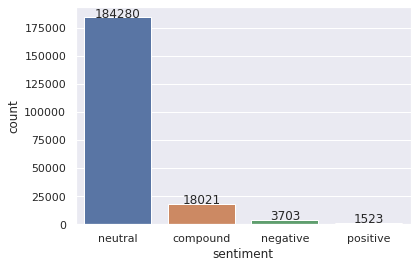

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x='sentiment', data=temp)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Neutral Words


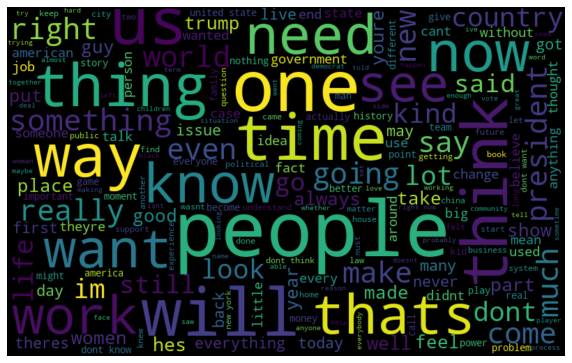

Negative Words


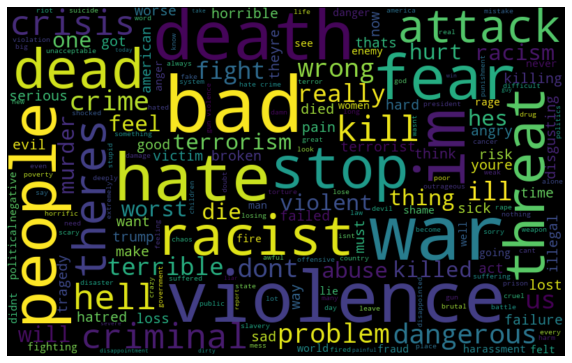

Positive Words


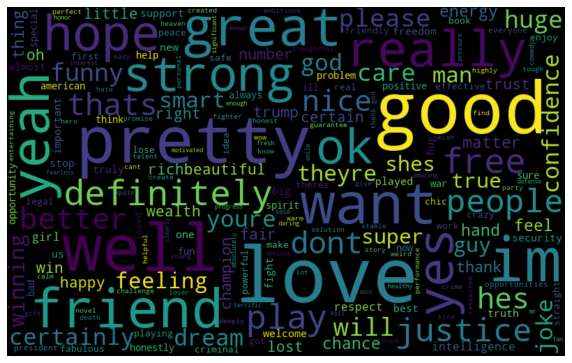

Compound Words


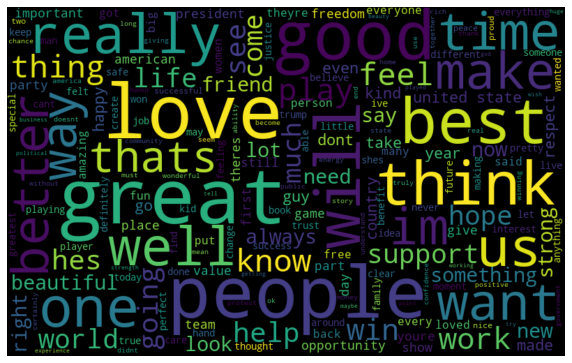

In [ ]:
print("Neutral Words")

neu_words =' '.join([text for text in df['quotation'][df['sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neu_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Negative Words")

neg_words =' '.join([text for text in df['quotation'][df['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Positive Words")

pos_words =' '.join([text for text in df['quotation'][df['sentiment'] == 2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Compound Words")

compound_words =' '.join([text for text in df['quotation'][df['sentiment'] == 3]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(compound_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


#Flair Sentiment Analyzer

In [ ]:

#flair.device = torch.device('cuda')
flair_sentiment = flair.models.TextClassifier.load('sentiment-fast')
#may need to use a faster model or batch processing 
def classify_sentiment_flair(doc):
  #  print(doc)
   s = flair.data.Sentence(doc)
   flair_sentiment.predict(s)
  #  print(s)
   #scores = [(sent.labels[0].values, sent.labels[0].score) for sent in s]
   if len(s) > 0:
    scores = s.labels[0]
    return scores.value
   else:
     return 0
  

applied_df_flair= data.copy()
applied_df_flair['sentiment'] = applied_df_flair['quotation'].apply(lambda quote: classify_sentiment_flair(quote))
applied_df_flair.head()

2021-12-16 18:09:21,103 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-fasttext-rnn/sentiment-en-mix-ft-rnn_v8.pt not found in cache, downloading to /tmp/tmpasd2bfyj


100%|██████████| 1241977025/1241977025 [00:54<00:00, 22679154.22B/s]

2021-12-16 18:10:16,282 copying /tmp/tmpasd2bfyj to cache at /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt


2021-12-16 18:10:21,646 removing temp file /tmp/tmpasd2bfyj
2021-12-16 18:10:21,811 loading file /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt
2021-12-16 18:12:19,923 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-12-16 18:13:34,881 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-12-16 18:15:27,976 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-12-16 18:16:34,706 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-12-16 18:18:50,175 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-12-16 18:22:39,531 Warning: An empty Sentence was created! Are there empty strings in your dataset?


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,sentiment
0,2019-04-17-024782,it is not a lowincome immigration,James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E,NEGATIVE
0,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E,POSITIVE
0,2019-05-09-055187,it makes it much more difficult for him to mak...,None,[],2019-05-09 18:11:29,1,"[[None, 0.6493], [President Bill Clinton, 0.27...",[http://mobile.nytimes.com/2019/05/09/world/as...,E,NEGATIVE
0,2019-10-31-056366,it puts me in a predicament,Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E,NEGATIVE
0,2019-01-04-001792,a pile of leaves,None,[],2019-01-04 10:00:07,1,"[[None, 0.8737], [Jason Fulford, 0.1263]]",[https://www.nytimes.com/2019/01/04/books/revi...,E,NEGATIVE


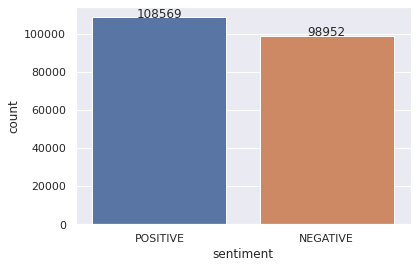

In [7]:
applied_df_flair = applied_df_flair[(applied_df_flair['sentiment'] == 'POSITIVE') | (applied_df_flair['sentiment'] == 'NEGATIVE')]
sns.set(style="darkgrid")
ax = sns.countplot(x='sentiment', data=applied_df_flair[['quotation','sentiment']])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Positive Words


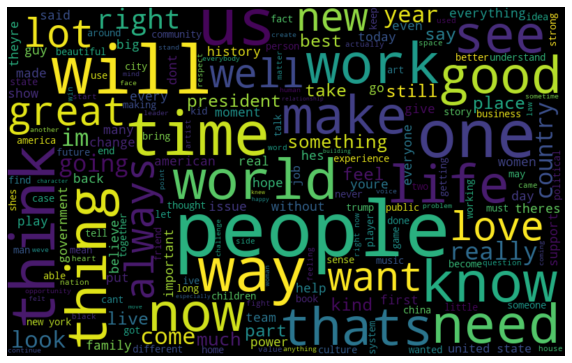

Negative Words


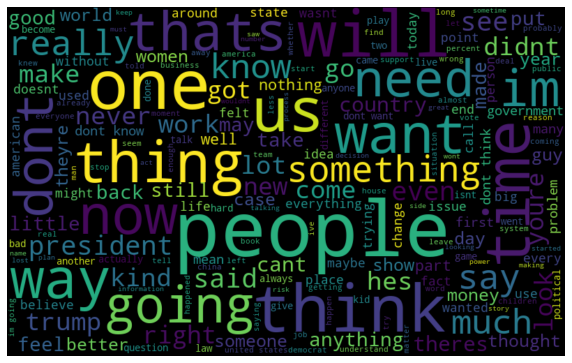

In [ ]:
df=applied_df_flair.copy()
print("Positive Words")

neu_words =' '.join([text for text in df['quotation'][df['sentiment'] == 'POSITIVE']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neu_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Negative Words")

neg_words =' '.join([text for text in df['quotation'][df['sentiment'] == 'NEGATIVE']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# BERTtopic

In [ ]:
from bertopic import BERTopic
topic_model = BERTopic(verbose=True)

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/ADA/quote-nytimes.csv')

In [ ]:
# data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
# list(data.columns)
data.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2019-04-17-024782,it is not a lowincome immigration,James Fisher,"['Q16213953', 'Q20707104', 'Q43143598', 'Q5888...",2019-04-17 13:31:18,1,"[['James Fisher', '0.7475'], ['None', '0.2525']]",['https://www.nytimes.com/2019/04/17/realestat...,E
1,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,['Q105756'],2019-04-02 14:58:33,2,"[['John Updike', '0.5856'], ['None', '0.4144']]",['https://www.nytimes.com/2019/04/02/opinion/v...,E
2,2019-05-09-055187,it makes it much more difficult for him to mak...,None,[],2019-05-09 18:11:29,1,"[['None', '0.6493'], ['President Bill Clinton'...",['http://mobile.nytimes.com/2019/05/09/world/a...,E
3,2019-10-31-056366,it puts me in a predicament,Xavier Becerra,['Q1855840'],2019-10-31 16:45:15,3,"[['Xavier Becerra', '0.9065'], ['None', '0.090...",['http://www.nytimes.com/2019/10/31/technology...,E
4,2019-01-04-001792,a pile of leaves,None,[],2019-01-04 10:00:07,1,"[['None', '0.8737'], ['Jason Fulford', '0.1263']]",['https://www.nytimes.com/2019/01/04/books/rev...,E


In [ ]:
dataset = data[['quotation', 'date']]
dataset.head()

,quotation,date
0,it is not a lowincome immigration,2019-04-17 13:31:18
1,a champion figure skater switching to roller s...,2019-04-02 14:58:33
2,it makes it much more difficult for him to mak...,2019-05-09 18:11:29
3,it puts me in a predicament,2019-10-31 16:45:15
4,a pile of leaves,2019-01-04 10:00:07


In [ ]:
# dataset.dropna()
dataset[dataset.quotation.apply(lambda x: str(x)]
dataset.head()

,quotation,date
0,it is not a lowincome immigration,2019-04-17 13:31:18
1,a champion figure skater switching to roller s...,2019-04-02 14:58:33
2,it makes it much more difficult for him to mak...,2019-05-09 18:11:29
3,it puts me in a predicament,2019-10-31 16:45:15
4,a pile of leaves,2019-01-04 10:00:07


In [ ]:
def remove_stop(document):
    document = ' '.join(word for word in document.split() if word.lower() not in STOPWORDS) 
    return document
# dataset['quotation']=dataset['quotation_x'].apply(lambda x: remove_stop(x))
dataset['quotation']=dataset['quotation'].apply(lambda x: str(x))
dataset['quotation']=dataset['quotation'].apply(lambda x: remove_stop(x))
dataset.head()

,quotation,date
0,lowincome immigration,2019-04-17 13:31:18
1,champion figure skater switching roller skates,2019-04-02 14:58:33
2,makes much difficult make compromises needed,2019-05-09 18:11:29
3,puts predicament,2019-10-31 16:45:15
4,pile leaves,2019-01-04 10:00:07


In [ ]:
sample=dataset.sample(n=100000,random_state=0)# sample size since model runs out of ram 
# sample = dataset
# sample.reset_index(inplace=True,drop=True)
sample.head()

,quotation,date
30621,dont think impacts trumps standing coal countr...,2019-10-30 17:44:01
45944,median consumer probably feels gets lots free ...,2019-03-17 19:22:36
94053,admitted phoebe sumter medical center observat...,2019-10-22 00:00:00
177455,didnt ask leg little bit bad right really need...,2019-04-10 18:07:14
76061,im dancer dont say im,2019-06-26 23:51:58


In [ ]:
data_in=sample['quotation'].values.tolist()
timestamps=sample['date'].values.tolist()

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english", min_df=10)
topic_model = BERTopic(vectorizer_model=vectorizer_model,verbose=True, calculate_probabilities=False, low_memory=True)

In [ ]:
topics, probs = topic_model.fit_transform(data_in)

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

2021-12-16 21:47:13,693 - BERTopic - Transformed documents to Embeddings
2021-12-16 21:50:06,403 - BERTopic - Reduced dimensionality with UMAP
2021-12-16 21:50:23,277 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name
0,-1,43636,-1_work_care_money_people
1,0,819,0_music_song_band_singing
2,1,724,1_women_gender_woman_female
3,2,688,2_food_restaurant_eat_kitchen
4,3,660,3_china_chinese_trade_talks
5,4,639,4_book_books_writing_writer
6,5,611,5_donald_donald trump_trump_president
7,6,521,6_college_students_education_schools
8,7,512,7_pitch_ball_balls_hitting
9,8,506,8_church_religious_religion_pray


In [ ]:
topics_over_time = topic_model.topics_over_time(data_in, topics, timestamps, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

20it [00:20,  1.00s/it]


In [ ]:
#topics_over_time.write_html("topics_over_time_2020.html", include_plotlyjs="cdn")
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10).write_html("/content/drive/MyDrive/ADA/topics_over_time_NYT.html", include_plotlyjs="cdn")

In [ ]:
fig = topic_model.visualize_topics(); fig

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
topic_nr = freq.iloc[0]["Topic"]  # We select a frequent topic
topic_model.get_topic(topic_nr)   # You can select a topic number as shown above

[('work', 0.0009470130843748347),
 ('care', 0.0008825016558572236),
 ('money', 0.0008761675776645036),
 ('people', 0.0008705145734056752),
 ('life', 0.0008668982230442837),
 ('like', 0.0008629269811893485),
 ('children', 0.0008619499726497116),
 ('going', 0.0008448494500952954),
 ('time', 0.000842656197442706),
 ('american', 0.0008386564359040355)]

topics_over_time.write_html("topics_over_time.html", include_plotlyjs="cdn")

In [ ]:
fig.write_html("/content/drive/MyDrive/ADA/Intertropic_distance_NYT.html", include_plotlyjs="cdn")

In [ ]:
print(topics[0])
topic_model.get_topic(topics[0])

83


[('carbon', 0.05384633253889752),
 ('energy', 0.03459721000756745),
 ('gas', 0.026105654190987686),
 ('clean', 0.021997939152860576),
 ('climate', 0.01506424127362158),
 ('fuel', 0.01364314809728672),
 ('standards', 0.01177312918320137),
 ('wind', 0.01081464868204205),
 ('efficiency', 0.010746244956685174),
 ('nuclear', 0.010307439337099844)]

In [ ]:
topic_model.save("/content/drive/MyDrive/ADA/topic_model_nyt")

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [ ]:
vv=zip(data_in,topics)
df= pd.DataFrame(vv, columns=['quotation','topic'])
print(df.shape)
df.head()
df.to_csv('/content/drive/MyDrive/ADA/quotes_topics.csv')

(100000, 2)


In [ ]:
data_in[0]

'dont think impacts trumps standing coal country importantly going go'

In [ ]:
sample['quotation'].iloc[0]==data_in[0]

True

In [ ]:
# df.quotation = df.quotation
# sample.quotation = sample.quotation.str


In [ ]:
df['quotation'].iloc[0]

'dont think impacts trumps standing coal country importantly going go'

In [ ]:
sample['quotation'].iloc[0]==df['quotation'].iloc[0]

True

In [ ]:
# print(sample['quotation'].shape)
fdf=pd.merge(df,sample,on=['quotation'])
print(fdf.shape)
fdf.head()

(101450, 3)


,quotation,topic,date
0,dont think impacts trumps standing coal countr...,83,2019-10-30 17:44:01
1,median consumer probably feels gets lots free ...,-1,2019-03-17 19:22:36
2,admitted phoebe sumter medical center observat...,922,2019-10-22 00:00:00
3,didnt ask leg little bit bad right really need...,609,2019-04-10 18:07:14
4,im dancer dont say im,25,2019-06-26 23:51:58


In [ ]:
print(fdf.shape)

(101450, 3)


In [ ]:
fdf.head()

,quotation,topic,date
0,dont think impacts trumps standing coal countr...,83,2019-10-30 17:44:01
1,median consumer probably feels gets lots free ...,-1,2019-03-17 19:22:36
2,admitted phoebe sumter medical center observat...,922,2019-10-22 00:00:00
3,didnt ask leg little bit bad right really need...,609,2019-04-10 18:07:14
4,im dancer dont say im,25,2019-06-26 23:51:58


In [ ]:
data['quotation'].iloc[1000]

'americans are a bit puritan in their kitchens they want everything neat and tidy they care too much about the toast crumbs'

In [ ]:
fdf.dropna()
fdf.shape

(101450, 3)

In [ ]:
print(data.shape)

(207527, 9)


In [ ]:
# tt=data.copy()
# tt['quotation'].apply(lambda x: str(x))
final=pd.merge(data,sample,on=['quotation'])

In [ ]:
# 'quotation',
final.shape

(1174, 10)

In [ ]:
final.head()

,quotation_x,topic,date,quoteID,quotation_y,speaker,qids,numOccurrences,probas,urls,phase
0,dont think impacts trumps standing coal countr...,83,2019-10-30 17:44:01,2019-10-30-094939,the narrative has been created in a pretty shr...,None,[],1,"[['None', '0.9499'], ['Donald Trump', '0.0315'...",['http://mobile.nytimes.com/2019/10/30/climate...,E
1,dont think impacts trumps standing coal countr...,83,2019-10-30 17:44:01,2019-10-30-034268,i dont think it impacts trumps standing in coa...,J. Pyle,['Q56846125'],1,"[['J. Pyle', '0.5218'], ['None', '0.4782']]",['http://mobile.nytimes.com/2019/10/30/climate...,E
2,dont think impacts trumps standing coal countr...,83,2019-10-30 17:44:01,2019-10-30-135895,you may find one device is taking up 30 percen...,Lisa Schmidt,"['Q4977446', 'Q59365703']",1,"[['Lisa Schmidt', '0.9223'], ['None', '0.0777']]",['http://mobile.nytimes.com/2019/10/30/climate...,E
3,dont think impacts trumps standing coal countr...,83,2019-10-30 17:44:01,2019-10-30-085872,symbolically its frustrating,J. Pyle,['Q56846125'],1,"[['J. Pyle', '0.8314'], ['None', '0.1686']]",['http://mobile.nytimes.com/2019/10/30/climate...,E
4,dont think impacts trumps standing coal countr...,83,2019-10-30 17:44:01,2019-10-30-032480,i can almost guarantee hes going to win the state,None,[],1,"[['None', '0.8366'], ['J. Pyle', '0.1634']]",['http://mobile.nytimes.com/2019/10/30/climate...,E


In [ ]:
final.head()

,quotation,date_x,topic,Unnamed: 0,quoteID,speaker,qids,date_y,numOccurrences,probas,urls,phase
0,dont think impacts trumps standing coal countr...,2019-10-30 17:44:01,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,median consumer probably feels gets lots free ...,2019-03-17 19:22:36,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,admitted phoebe sumter medical center observat...,2019-10-22 00:00:00,922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,didnt ask leg little bit bad right really need...,2019-04-10 18:07:14,609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,im dancer dont say im,2019-06-26 23:51:58,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
